In [1]:
import os
import acquire_aqi as acquire
import prepare_aqi as prepare
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
plt.style.use('fivethirtyeight')

from datetime import timedelta, datetime
from pylab import rcParams

# to explode the DataFrames and avoid truncation
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
df = acquire.read_data('cosa-air-quality.csv')

In [3]:
df = prepare.lowercase_and_rename(df)

In [4]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()

In [5]:
df1 = prepare.ready_df1(df)

In [6]:
df1.sort_values('timestamp').reset_index().drop(columns=('index')).head().T

,0,1,2,3,4
monitor_name,CSA01 Houston Riverwalk,CSA01 Houston Riverwalk,CSA01 Houston Riverwalk,CSA01 Houston Riverwalk,CSA20 Woodlawn Lake Park
active,True,True,True,True,True
zip,78205,78205,78205,78205,78210
state,TX,TX,TX,TX,TX
city,San Antonio,San Antonio,San Antonio,San Antonio,San Antonio
street,141 E Houston St,141 E Houston St,141 E Houston St,141 E Houston St,189 Josephine Tobin
timestamp,2019-02-04 20:02:53,2019-02-04 20:12:53,2019-02-04 20:22:53,2019-02-04 20:32:53,2019-02-04 20:32:53
humidity,61,61,63,64,48
carbon_monoxide,1642,1595,1329,1670,0
carbon_monoxide_aqi,18,18,17,17,0


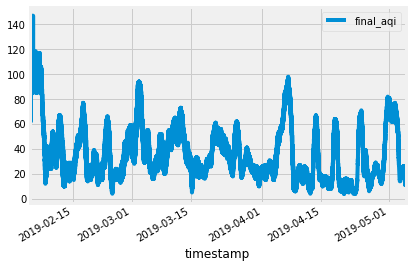

In [7]:
by_date = df1.groupby(['timestamp'])['final_aqi'].mean().reset_index()
by_date.plot(x='timestamp', y='final_aqi');

In [8]:
df1.timestamp.nunique()

26041

In [9]:
timedelta(df1.timestamp.nunique()) == (df1.timestamp.max() - df1.timestamp.min()) + timedelta(days=1)

False

In [10]:
# Observations per monitor
print(df1.monitor_name.value_counts().unique())

[12821 12819 12814]


In [11]:
df1 = df1.sort_values('timestamp')
df1 = df1.set_index('timestamp')

In [12]:
train = df1[:'2019-04']
test = df1['2019-05':]
print(train.nunique())
print(test.nunique())

monitor_name              3
active                    1
zip                       2
state                     1
city                      1
street                    3
humidity                 77
carbon_monoxide        3815
carbon_monoxide_aqi      49
particulate5             72
particulate5_aqi        111
particulate10            86
particulate10_aqi        39
final_aqi               108
temperature              39
dtype: int64
monitor_name             3
active                   1
zip                      2
state                    1
city                     1
street                   3
humidity                55
carbon_monoxide        244
carbon_monoxide_aqi     20
particulate5            44
particulate5_aqi        74
particulate10           51
particulate10_aqi       26
final_aqi               74
temperature             21
dtype: int64


In [13]:
aqi = train.resample('D').final_aqi.mean()

TypeError: float() argument must be a string or a number, not 'Period'

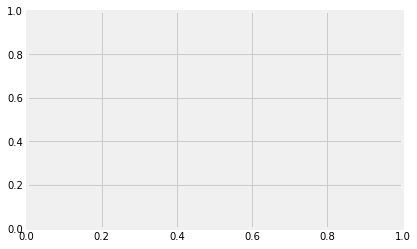

In [14]:
aqi.plot()

In [ ]:
aqi.resample('W').mean().plot()

In [ ]:
aqi.resample('MS').mean().plot()

In [ ]:
aqi.rolling(5).mean().plot(figsize=(12, 4))

In [ ]:
aqi.diff(periods=10).plot(figsize=(12, 4))

In [ ]:
from pylab import rcParams
decomposition = sm.tsa.seasonal_decompose(aqi, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
pd.plotting.lag_plot(aqi)

In [ ]:
df_corr = pd.concat([aqi.shift(1), aqi], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)



# MODEL

In [ ]:
aqi = aqi.to_frame()

In [ ]:
aqi.reset_index(inplace=True)

In [ ]:
aqi

In [ ]:
aqi.info()

In [ ]:
aqi = aqi.rename(index=str, columns={'timestamp':'ds',
                                     'final_aqi':'y'})

In [ ]:
aqi

In [ ]:
aqi = aqi.groupby(['ds'])['y'].mean().reset_index()


In [ ]:
aqi.head()

In [ ]:
# sns.scatterplot(d_df.ds, d_df.y)
# df = d_df.set_index('ds')
plt.figure(figsize=(16,6))
sns.tsplot(aqi.y)

In [ ]:
aqi['cap'] = 600
aqi['floor'] = 100

m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9)
m.fit(aqi)

In [ ]:
future = m.make_future_dataframe(periods=180)
future['cap'] = 600
future['floor'] = 100
print(future.head())
print(future.tail())
print(aqi.tail())

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='4 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

In [ ]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')